In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import colors
from time import time
from tqdm import tqdm

from util import decode_npy

In [2]:
# data-relevant constants
DF = pd.read_csv('../data/main_table.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'

In [3]:
# plot fontsize settings

SMALL_FONT_SIZE = 22
MEDIUM_FONT_SIZE = 28
LARGE_FONT_SIZE = 28

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [7]:
BINSIZE_X, BINSIZE_Y = 1, 0.002
MIN_WVL, MAX_WVL = 390, 900

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22517/22517 [00:18<00:00, 1246.42it/s]


spent 5.397s binning
spent 0.012s drawing histogram
spent 2.839s finding median
spent 2.962s finding 75th pct
spent 2.995s finding 25th pct
spent 0.001s drawing median etc
total time spent: 34.562s


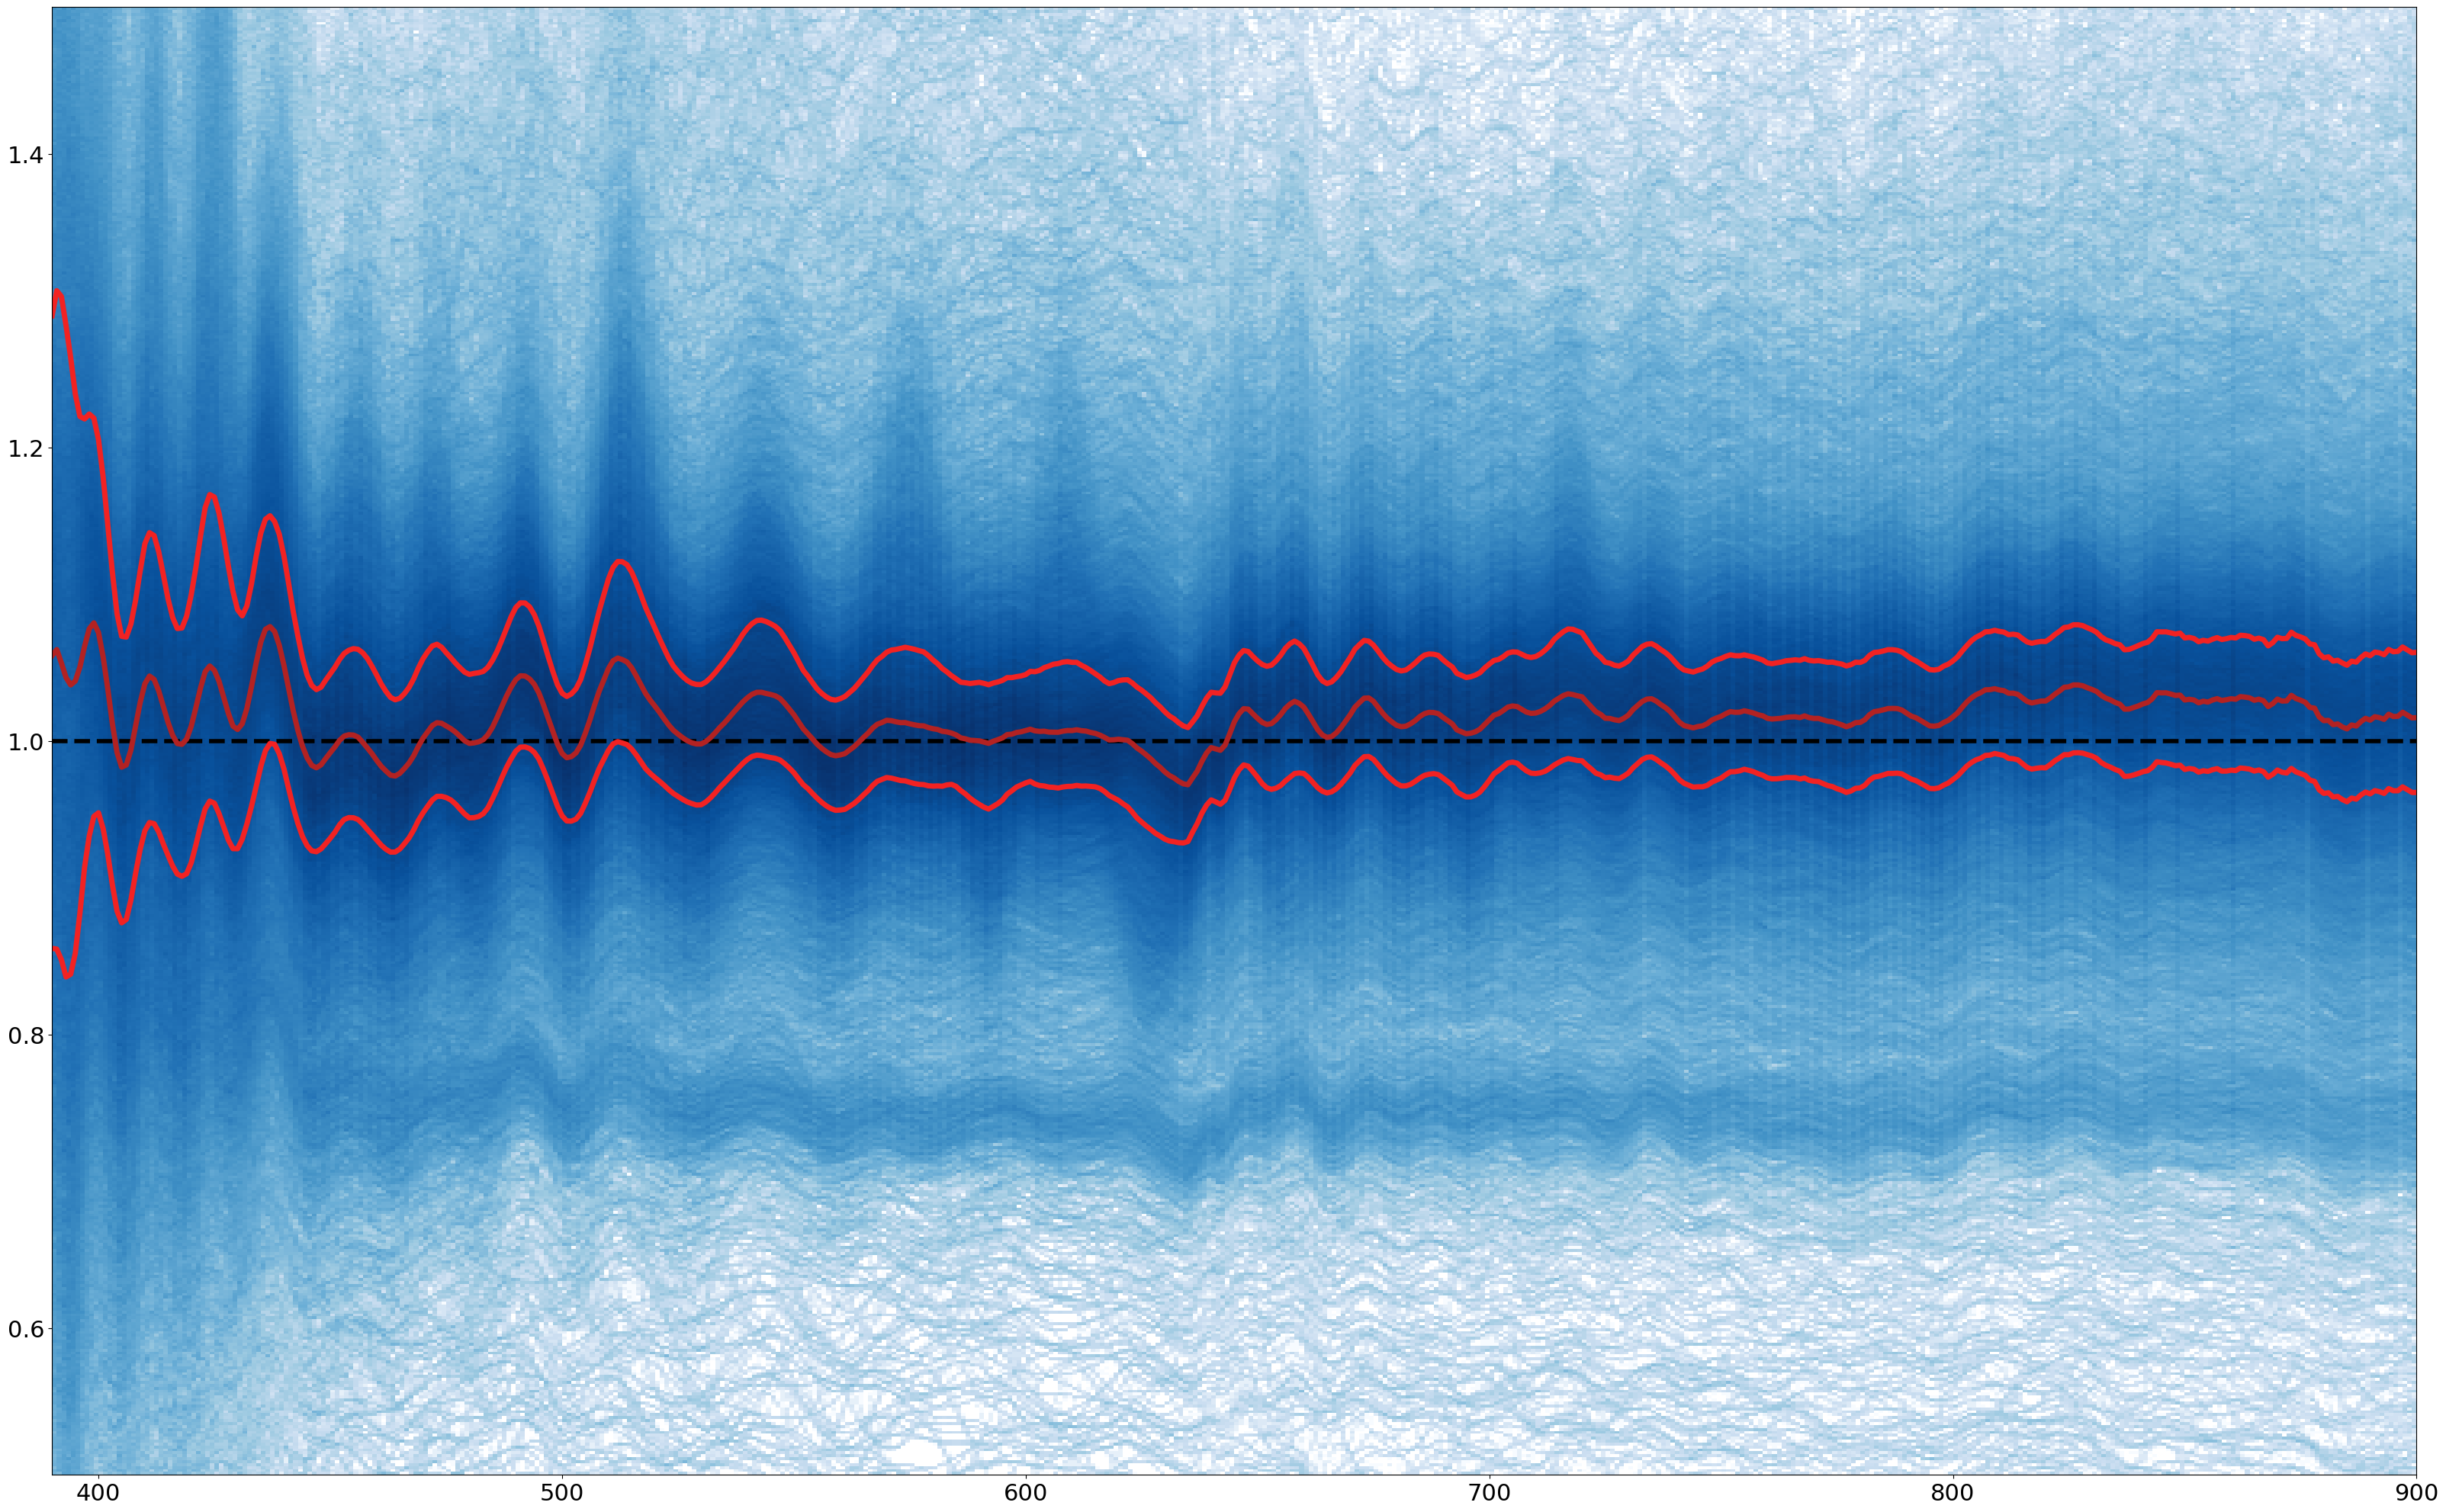

In [8]:
t00 = time()

plt.figure(figsize=(40, 25))
plt.xlim(MIN_WVL, MAX_WVL)
plt.ylim(0.5, 1.5)
plt.axhline(1, c='#000000', lw=4, ls='--')

bin_centers_x = np.arange(MIN_WVL, MAX_WVL+1, BINSIZE_X)
bin_centers_y = np.arange(0.5, 1.50001, BINSIZE_Y)

binned_qs = [ [] for _ in range(len(bin_centers_x)) ]

n_found, n_not_found = 0, 0
flat_sampling, flat_qs = [], []
for gaia_id in tqdm(DF[:][GAIA_ID_COLNAME]):
    try:
        sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
    except:
        print('Could not find an SDSS ID corresponding to the provided Gaia ID')
        continue

    try:
        spectra = decode_npy(f'../data/spectra/spectra_G{gaia_id}_S{sdss_id}.npy')
        n_found += 1
    except:
        n_not_found += 1
        continue
        
    sampling = spectra['sampling']
    qs = spectra['q']
    
    mask = (sampling > MIN_WVL) & (sampling < MAX_WVL)
    
    sampling = sampling[mask]
    qs = qs[mask]
    
    flat_sampling.extend(sampling)
    flat_qs.extend(qs)

    floors = np.floor(sampling).astype(np.int64)
    closer_to_higher = (sampling - floors) > 0.5

    indices = floors - MIN_WVL + closer_to_higher
    for bin_, q in zip(indices, qs):
        binned_qs[bin_].append(q)

t0 = time()
vals, xbins, ybins = np.histogram2d(flat_sampling, flat_qs, bins=(bin_centers_x, bin_centers_y))
print(f'spent {time()-t0:.3f}s binning')

t0 = time()
plt.pcolormesh(xbins, ybins, vals.T, cmap='Blues', norm=colors.LogNorm())
print(f'spent {time()-t0:.3f}s drawing histogram')

t0 = time()
q_med = [ np.median(v) for v in binned_qs ]
print(f'spent {time()-t0:.3f}s finding median')

t0 = time()
q_75 = [ np.quantile(v, 0.75) for v in binned_qs ]
print(f'spent {time()-t0:.3f}s finding 75th pct')

t0 = time()
q_25 = [ np.quantile(v, 0.25) for v in binned_qs ]
print(f'spent {time()-t0:.3f}s finding 25th pct')

t0 = time()
plt.plot(bin_centers_x, q_med, c='#b22222', lw=5, ls='-')
plt.plot(bin_centers_x, q_25, c='#f22222', lw=5, ls='-')
plt.plot(bin_centers_x, q_75, c='#f22222', lw=5, ls='-')
print(f'spent {time()-t0:.3f}s drawing median etc')

print(f'total time spent: {time()-t00:.3f}s')

plt.show()